# Part-of-Speech and Sequence Annotation
A reimplementation of the Senna program described in [_Natural language processing (almost) from scratch_](https://arxiv.org/abs/1103.0398) by Collobert et al. (2011) with PyTorch.
## Part 3: Annotation with Conditional Random Fields
This part contains a reimplementation of the conditional random fields (CRF) class with two ways to compute the $\delta$: one proposed in the paper, Sect. 3.3.2, and another one adopted by the `torchcrf` module. The CRF class is purely stochastic and cannot process mini-batches.


__Author__: Pierre Nugues

## Python Headers

A few things to download

In [1]:
#!pip install conlleval
"""
!wget https://data.deepai.org/conll2003.zip
!unzip -u conll2003.zip
!mkdir datasets/conll2003
!mv train.txt valid.txt test.txt datasets/conll2003
!rm conll2003.zip
"""

'\n!wget https://data.deepai.org/conll2003.zip\n!unzip -u conll2003.zip\n!mkdir datasets/conll2003\n!mv train.txt valid.txt test.txt datasets/conll2003\n!rm conll2003.zip\n'

### The Modules

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import numpy as np
from sklearn.feature_extraction import DictVectorizer
import conlleval

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import ud_datasets
from conll_dictorizer import CoNLLDictorizer

### Some Parameters

The words to build the vocabulary and the embedding vectors:
* 0: Random embeddings: The embedding table contains only the words in the corpus. 
* 1: Senna embeddings only: The embedding table contains only the words in the embeddings vocabulary (Senna). All the other words share an `UNK` symbol and vector
* 2: Senna + word embeddings: We create an embedding table for the words in corpus and in Senna. We  initialize the embeddings with Senna vectors when available, otherwise random

In [3]:
USE_EMBEDDINGS = 2

In [4]:
CORPUS = 'CONLL2003'   # 'EWT' 'CONLL2003' 'CONLL2000'
TAGSET = 'IOBES'  # 'BIO' 'IOBES'

In [5]:
DATASET_PATH = 'datasets/'
MODEL_PATH = 'models/'

In [6]:
# The embedding files. You will possibly need to adjust the path
EMBEDDINGS_FILE = DATASET_PATH + 'senna/embeddings/embeddings.txt'
WORD_FILE = DATASET_PATH + 'senna/hash/words.lst'

In [7]:
EMBEDDING_DIM = 50
CAPS_EMBEDDING_DIM = 5
N_HU_1 = 300
MINI_CORPUS = False
LOWERCASE = True
D_WIN = 2  # Context to the right and left. Size of the window 2 * D_WIN + 1, d_win in Senna paper
SENNA_DELTAS = True # We compute the deltas as in the paper, Sect. 3.3.2, or not

In [8]:
EPOCHS = 60
LR = 0.01
BATCH_SIZE = 1

In [9]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### Embeddings

In [10]:
def read_embeddings(word_file: str, embs_file: str) -> dict[str, torch.FloatTensor]:
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    words = []
    with open(word_file) as f:
        for line in f:
            word = line.strip()
            words += [word]
    with open(embs_file) as f:
        for i, line in enumerate(f):
            values = line.strip().split()
            word = words[i]
            vector = torch.FloatTensor(
                list(map(float, values)))
            embeddings[word] = vector
    return embeddings

In [11]:
embeddings_dict = read_embeddings(WORD_FILE, EMBEDDINGS_FILE)
embedded_words = sorted(list(embeddings_dict.keys()))

### Loading the Corpus
Collobert et al. did not describe their validation experiments. In CoNLL 2000, there is no validation set. Although not a good practice, we use the test set to validate the training procedure. We also follow Attardi, https://github.com/attardi/deepnl, and we merge the CoNLL 2003 training and validation sets.

In [12]:
from datetime import datetime
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2025-03-04 13:20:46'

In [13]:
if CORPUS == 'EWT':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_en_ewt()
    MODEL_NAME = 'pos_model'
elif CORPUS == 'CONLL2003':
    train_file = DATASET_PATH + 'conll2003/train.txt'
    val_file = DATASET_PATH + 'conll2003/valid.txt'
    test_file = DATASET_PATH + 'conll2003/test.txt'
    with open(train_file) as f:
        train_sentences = f.read().strip()
    with open(val_file) as f:
        val_sentences = f.read().strip()
    with open(test_file) as f:
        test_sentences = f.read().strip()
    MODEL_NAME = 'ner_model'
    column_names = ['FORM', 'PPOS', 'PCHUNK', 'NER']
elif CORPUS == 'CONLL2000':
    train_file = DATASET_PATH + 'conll2000/train.txt'
    test_file = DATASET_PATH + 'conll2000/test.txt'
    with open(train_file) as f:
        train_sentences = f.read().strip()
    with open(test_file) as f:
        test_sentences = f.read().strip()
    column_names = ['FORM', 'PPOS', 'CHUNK']
    MODEL_NAME = 'chunker_model'

In [14]:
MODEL_FILE = MODEL_PATH + MODEL_NAME + '_' + \
    datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '.pt'
MODEL_FILE

'models/ner_model_2025-03-04 13:20:46.pt'

### Experimental setup

We use the test set as validation set for CoNLL 2000 and 2003. We add the validation set to the training set in CoNLL 2003

In [15]:
if CORPUS == 'CONLL2003':
    train_sentences += '\n\n' + val_sentences
    val_sentences = test_sentences
if CORPUS == 'CONLL2000':
    val_sentences = test_sentences

## Dictorizing the corpus

We store the corpus word in a dictionary, where the keys are the CoNLL-U columns

In [16]:
if CORPUS == 'EWT':
    conll_dict = CoNLLDictorizer(column_names)
elif CORPUS in ['CONLL2000', 'CONLL2003']:
    conll_dict = CoNLLDictorizer(column_names, col_sep=' +')

In [17]:
train_dict = conll_dict.transform(train_sentences)
val_dict = conll_dict.transform(val_sentences)
test_dict = conll_dict.transform(test_sentences)

In [18]:
train_dict[0][:10]

[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}]

In [19]:
train_dict[:3]

[[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}],
 [{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-ORG'},
  {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
  {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
  {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'B-MISC'},
  {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}],
 [{'FORM': 'Peter', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'Blackburn', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'I-PER'}]]

Conversion of BIO to IOBES

In [20]:
def BIO2IOBES(sent_dicts: list[dict], tag='CHUNK'):
    for sent_dict in sent_dicts:
        for idx in range(len(sent_dict) - 1):
            # B O -> S O
            if sent_dict[idx][tag][0] == 'B' and sent_dict[idx + 1][tag][0] == 'O':
                sent_dict[idx][tag] = 'S' + sent_dict[idx][tag][1:]
            # B-NP B-VP -> E-NP B-VP
            elif sent_dict[idx][tag][0] == 'B' and sent_dict[idx + 1][tag][0] == 'B':
                sent_dict[idx][tag] = 'S' + sent_dict[idx][tag][1:]
            # I O -> E O
            elif sent_dict[idx][tag][0] == 'I' and sent_dict[idx + 1][tag][0] == 'O':
                sent_dict[idx][tag] = 'E' + sent_dict[idx][tag][1:]
            # I B -> E B
            elif sent_dict[idx][tag][0] == 'I' and sent_dict[idx + 1][tag][0] == 'B':
                sent_dict[idx][tag] = 'E' + sent_dict[idx][tag][1:]
            else:
                pass

        # Last word
        if sent_dict[-1][tag][0] == 'B':
            sent_dict[-1][tag] = 'S' + sent_dict[-1][tag][1:]
        elif sent_dict[-1][tag][0] == 'I':
            sent_dict[-1][tag] = 'E' + sent_dict[-1][tag][1:]
        else:
            pass
    return sent_dicts

In [21]:
if TAGSET == 'IOBES' and CORPUS in ['CONLL2000', 'CONLL2003']:
    if CORPUS == 'CONLL2000':
        tag = 'CHUNK'
    elif CORPUS == 'CONLL2003':
        tag = 'NER'
    train_dict = BIO2IOBES(train_dict, tag)
    val_dict = BIO2IOBES(val_dict, tag)
    test_dict = BIO2IOBES(test_dict, tag)

In [22]:
train_dict[:4]

[[{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O'}],
 [{'FORM': 'EU', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'S-ORG'},
  {'FORM': 'rejects', 'PPOS': 'VBZ', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'German', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'S-MISC'},
  {'FORM': 'call', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': 'to', 'PPOS': 'TO', 'PCHUNK': 'B-VP', 'NER': 'O'},
  {'FORM': 'boycott', 'PPOS': 'VB', 'PCHUNK': 'I-VP', 'NER': 'O'},
  {'FORM': 'British', 'PPOS': 'JJ', 'PCHUNK': 'B-NP', 'NER': 'S-MISC'},
  {'FORM': 'lamb', 'PPOS': 'NN', 'PCHUNK': 'I-NP', 'NER': 'O'},
  {'FORM': '.', 'PPOS': '.', 'PCHUNK': 'O', 'NER': 'O'}],
 [{'FORM': 'Peter', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'B-PER'},
  {'FORM': 'Blackburn', 'PPOS': 'NNP', 'PCHUNK': 'I-NP', 'NER': 'E-PER'}],
 [{'FORM': 'BRUSSELS', 'PPOS': 'NNP', 'PCHUNK': 'B-NP', 'NER': 'S-LOC'},
  {'FORM': '1996-08-22', 'PPOS': 'CD', 'PCHUNK': 'I-NP', 'NER': 'O'}]]

We extract the case information. We follow the Senna source code

In [23]:
def add_case_info(row: dict):
    """Same as in Senna code"""
    if (any(char.isupper() for char in row['FORM']) and
            not any(char.islower() for char in row['FORM'])):
        row['CAPS'] = 'ALL_CAPS'
    elif row['FORM'][0].isupper():
        row['CAPS'] = 'INIT_CAP'
    elif any(char.isupper() for char in row['FORM']):
        row['CAPS'] = 'HAS_CAP'
    else:
        row['CAPS'] = 'NO_CAPS'

In [24]:
for sent_dict in train_dict:
    for row in sent_dict:
        add_case_info(row)
for sent_dict in val_dict:
    for row in sent_dict:
        add_case_info(row)
for sent_dict in test_dict:
    for row in sent_dict:
        add_case_info(row)

In [25]:
if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'FORM': '-DOCSTART-', 'PPOS': '-X-', 'PCHUNK': '-X-', 'NER': 'O', 'CAPS': 'ALL_CAPS'}]


## Extracting $X_{cat}$ and $\mathbf{y}$ the Context and Dictorizing it
We extract windows of five words surrounding the word and we build a table. We do the same with the case information.

In [26]:
def extract_cols(sent_dict, x='FORM', y='UPOS'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [27]:
if CORPUS == 'EWT':
    x_input = 'FORM'
    y_output = 'UPOS'
elif CORPUS == 'CONLL2000':
    x_input = 'FORM'
    y_output = 'CHUNK'
elif CORPUS == 'CONLL2003':
    x_input = 'FORM'
    y_output = 'NER'

train_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
             for sent_dict in test_dict]

In [28]:
train_sent_words, train_sent_pos = zip(*train_cols)
val_sent_words, val_sent_pos = zip(*val_cols)
test_sent_words, test_sent_pos = zip(*test_cols)

We set the words in lowercase

In [29]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sent_words))
                        for sent_words in train_sent_words]
    val_sent_words = [list(map(str.lower, sent_words))
                      for sent_words in val_sent_words]
    test_sent_words = [list(map(str.lower, sent_words))
                       for sent_words in test_sent_words]

In [30]:
train_sent_words[8131]

['he',
 'said',
 'talbott',
 ',',
 'who',
 'was',
 'scheduled',
 'to',
 'return',
 'on',
 'tuesday',
 ',',
 'would',
 'also',
 'to',
 'meet',
 'his',
 'canadian',
 'counterpart',
 ',',
 'gordon',
 'smith',
 ',',
 'in',
 'ottawa',
 'for',
 'talks',
 'that',
 'would',
 'include',
 'the',
 'situation',
 'in',
 'haiti',
 '.']

### Extracting the Caps

In [31]:
if CORPUS == 'EWT':
    x_input = 'CAPS'
    y_output = 'UPOS'
elif CORPUS == 'CONLL2000':
    x_input = 'CAPS'
    y_output = 'CHUNK'
elif CORPUS == 'CONLL2003':
    x_input = 'CAPS'
    y_output = 'NER'

train_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                   for sent_dict in train_dict]
val_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                 for sent_dict in val_dict]
test_caps_cols = [extract_cols(sent_dict, x=x_input, y=y_output)
                  for sent_dict in test_dict]

In [32]:
train_sent_caps, _ = zip(*train_caps_cols)
val_sent_caps, _ = zip(*val_caps_cols)
test_sent_caps, _ = zip(*test_caps_cols)

In [33]:
train_sent_caps[8131]

['INIT_CAP',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'NO_CAPS',
 'INIT_CAP',
 'NO_CAPS']

In [34]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3  # We do not use BOS and EOS
# We will pad y with 0

### Building the $X$ and $\mathbf{y}$ Categorical Matrices

In [35]:
def create_X_cat(sentence: list[str],
                 w_size: int = D_WIN) -> list[dict[int: str]]:
    start_pads = ['__BOS__'] * w_size
    end_pads = ['__EOS__'] * w_size
    sentence = start_pads + sentence + end_pads
    # We extract the features
    X = []
    for i in range(len(sentence) - 2 * w_size):
        x = []
        for j in range(2 * w_size + 1):
            x += [sentence[i + j]]
        X += [x]
    X = [dict(enumerate(x)) for x in X]
    return X

In [36]:
create_X_cat(train_sent_words[3000], w_size=D_WIN)

[{0: '__BOS__', 1: '__BOS__', 2: 'hong', 3: 'kong', 4: '1996-08-23'},
 {0: '__BOS__', 1: 'hong', 2: 'kong', 3: '1996-08-23', 4: '__EOS__'},
 {0: 'hong', 1: 'kong', 2: '1996-08-23', 3: '__EOS__', 4: '__EOS__'}]

In [37]:
create_X_cat(train_sent_caps[3000])

[{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: 'ALL_CAPS', 4: 'NO_CAPS'},
 {0: '__BOS__', 1: 'ALL_CAPS', 2: 'ALL_CAPS', 3: 'NO_CAPS', 4: '__EOS__'},
 {0: 'ALL_CAPS', 1: 'ALL_CAPS', 2: 'NO_CAPS', 3: '__EOS__', 4: '__EOS__'}]

In [38]:
X_train_cat = [create_X_cat(sent) for sent in train_sent_words]
X_val_cat = [create_X_cat(sent) for sent in val_sent_words]
X_test_cat = [create_X_cat(sent) for sent in test_sent_words]

In [39]:
X_train_cat[:3]

[[{0: '__BOS__', 1: '__BOS__', 2: '-docstart-', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'eu', 3: 'rejects', 4: 'german'},
  {0: '__BOS__', 1: 'eu', 2: 'rejects', 3: 'german', 4: 'call'},
  {0: 'eu', 1: 'rejects', 2: 'german', 3: 'call', 4: 'to'},
  {0: 'rejects', 1: 'german', 2: 'call', 3: 'to', 4: 'boycott'},
  {0: 'german', 1: 'call', 2: 'to', 3: 'boycott', 4: 'british'},
  {0: 'call', 1: 'to', 2: 'boycott', 3: 'british', 4: 'lamb'},
  {0: 'to', 1: 'boycott', 2: 'british', 3: 'lamb', 4: '.'},
  {0: 'boycott', 1: 'british', 2: 'lamb', 3: '.', 4: '__EOS__'},
  {0: 'british', 1: 'lamb', 2: '.', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'peter', 3: 'blackburn', 4: '__EOS__'},
  {0: '__BOS__', 1: 'peter', 2: 'blackburn', 3: '__EOS__', 4: '__EOS__'}]]

In [40]:
X_train_caps_cat = [create_X_cat(sent) for sent in train_sent_caps]
X_val_caps_cat = [create_X_cat(sent) for sent in val_sent_caps]
X_test_caps_cat = [create_X_cat(sent) for sent in test_sent_caps]

In [41]:
X_train_caps_cat[:3]

[[{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: 'NO_CAPS', 4: 'INIT_CAP'},
  {0: '__BOS__', 1: 'ALL_CAPS', 2: 'NO_CAPS', 3: 'INIT_CAP', 4: 'NO_CAPS'},
  {0: 'ALL_CAPS', 1: 'NO_CAPS', 2: 'INIT_CAP', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'INIT_CAP', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'INIT_CAP'},
  {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'INIT_CAP', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'INIT_CAP', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'INIT_CAP', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: '__EOS__'},
  {0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'INIT_CAP', 3: 'INIT_CAP', 4: '__EOS__'},
  {0: '__BOS__', 1: 'INIT_CAP', 2: 'INIT_CAP', 3: '__EOS__', 4: '__EOS__'}]]

In [42]:
y_train_cat = train_sent_pos
y_val_cat = val_sent_pos
y_test_cat = test_sent_pos

In [43]:
y_train_cat[:3]

(['O'],
 ['S-ORG', 'O', 'S-MISC', 'O', 'O', 'O', 'S-MISC', 'O', 'O'],
 ['B-PER', 'E-PER'])

### Running the Feature Extraction

We extract all the words

In [44]:
X_train_cat[:3]

[[{0: '__BOS__', 1: '__BOS__', 2: '-docstart-', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'eu', 3: 'rejects', 4: 'german'},
  {0: '__BOS__', 1: 'eu', 2: 'rejects', 3: 'german', 4: 'call'},
  {0: 'eu', 1: 'rejects', 2: 'german', 3: 'call', 4: 'to'},
  {0: 'rejects', 1: 'german', 2: 'call', 3: 'to', 4: 'boycott'},
  {0: 'german', 1: 'call', 2: 'to', 3: 'boycott', 4: 'british'},
  {0: 'call', 1: 'to', 2: 'boycott', 3: 'british', 4: 'lamb'},
  {0: 'to', 1: 'boycott', 2: 'british', 3: 'lamb', 4: '.'},
  {0: 'boycott', 1: 'british', 2: 'lamb', 3: '.', 4: '__EOS__'},
  {0: 'british', 1: 'lamb', 2: '.', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'peter', 3: 'blackburn', 4: '__EOS__'},
  {0: '__BOS__', 1: 'peter', 2: 'blackburn', 3: '__EOS__', 4: '__EOS__'}]]

In [45]:
corpus_words = [value.lower() for l in X_train_cat for x in l
                for value in x.values()]
corpus_words = sorted(set(corpus_words))

print('# unique words seen in training corpus:', len(corpus_words))

# unique words seen in training corpus: 23868


We extract all the caps

In [46]:
corpus_caps = [value for l in X_train_caps_cat for x in l
               for value in x.values()]
corpus_caps = sorted(set(corpus_caps))
corpus_caps

['ALL_CAPS', 'HAS_CAP', 'INIT_CAP', 'NO_CAPS', '__BOS__', '__EOS__']

In [47]:
embeddings_words = embeddings_dict.keys()
print('Words in Senna:',  len(embeddings_dict.keys()))
if USE_EMBEDDINGS == 0:
    vocabulary = set(corpus_words)
elif USE_EMBEDDINGS == 1:
    # If we only use the words from Senna
    vocabulary = set(list(embeddings_words))
elif USE_EMBEDDINGS == 2:
    vocabulary = set(corpus_words + list(embeddings_words))

Words in Senna: 130000


In [48]:
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary) + 2)  # unk and pad

# unique words in the vocabulary: embeddings and corpus: 136492


In [49]:
idx2word = dict(enumerate(sorted(vocabulary), start=2))  # UNK: 0 and PAD: 1
word2idx = {v: k for k, v in idx2word.items()}

We set the words in lowercase as SENNA is in lowercase and we replace them with their index. The unknown word has the index 0.

In [50]:
X_train_cat[:3]

[[{0: '__BOS__', 1: '__BOS__', 2: '-docstart-', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'eu', 3: 'rejects', 4: 'german'},
  {0: '__BOS__', 1: 'eu', 2: 'rejects', 3: 'german', 4: 'call'},
  {0: 'eu', 1: 'rejects', 2: 'german', 3: 'call', 4: 'to'},
  {0: 'rejects', 1: 'german', 2: 'call', 3: 'to', 4: 'boycott'},
  {0: 'german', 1: 'call', 2: 'to', 3: 'boycott', 4: 'british'},
  {0: 'call', 1: 'to', 2: 'boycott', 3: 'british', 4: 'lamb'},
  {0: 'to', 1: 'boycott', 2: 'british', 3: 'lamb', 4: '.'},
  {0: 'boycott', 1: 'british', 2: 'lamb', 3: '.', 4: '__EOS__'},
  {0: 'british', 1: 'lamb', 2: '.', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'peter', 3: 'blackburn', 4: '__EOS__'},
  {0: '__BOS__', 1: 'peter', 2: 'blackburn', 3: '__EOS__', 4: '__EOS__'}]]

In [51]:
for s_train_cat in X_train_cat:
    for x_train_cat in s_train_cat:
        for word in x_train_cat:
            x_train_cat[word] = word2idx.get(
                x_train_cat[word].lower(), UNK_IDX)

for s_val_cat in X_val_cat:
    for x_val_cat in s_val_cat:
        for word in x_val_cat:
            x_val_cat[word] = word2idx.get(
                x_val_cat[word].lower(), UNK_IDX)

for s_test_cat in X_test_cat:
    for x_test_cat in s_test_cat:
        for word in x_test_cat:
            x_test_cat[word] = word2idx.get(
                x_test_cat[word].lower(), UNK_IDX)

In [52]:
X_train_cat[:5]

[[{0: 6168, 1: 6168, 2: 793, 3: 6169, 4: 6169}],
 [{0: 6168, 1: 6168, 2: 43539, 3: 102381, 4: 51127},
  {0: 6168, 1: 43539, 2: 102381, 3: 51127, 4: 23294},
  {0: 43539, 1: 102381, 2: 51127, 3: 23294, 4: 123348},
  {0: 102381, 1: 51127, 2: 23294, 3: 123348, 4: 20585},
  {0: 51127, 1: 23294, 2: 123348, 3: 20585, 4: 21362},
  {0: 23294, 1: 123348, 2: 20585, 3: 21362, 4: 70048},
  {0: 123348, 1: 20585, 2: 21362, 3: 70048, 4: 794},
  {0: 20585, 1: 21362, 2: 70048, 3: 794, 4: 6169},
  {0: 21362, 1: 70048, 2: 794, 3: 6169, 4: 6169}],
 [{0: 6168, 1: 6168, 2: 93450, 3: 18843, 4: 6169},
  {0: 6168, 1: 93450, 2: 18843, 3: 6169, 4: 6169}],
 [{0: 6168, 1: 6168, 2: 21745, 3: 3285, 4: 6169},
  {0: 6168, 1: 21745, 2: 3285, 3: 6169, 4: 6169}],
 [{0: 6168, 1: 6168, 2: 121983, 3: 43697, 4: 29447},
  {0: 6168, 1: 121983, 2: 43697, 3: 29447, 4: 106629},
  {0: 121983, 1: 43697, 2: 29447, 3: 106629, 4: 88585},
  {0: 43697, 1: 29447, 2: 106629, 3: 88585, 4: 122699},
  {0: 29447, 1: 106629, 2: 88585, 3: 122699

In [53]:
capset = sorted(set(corpus_caps))
capset

['ALL_CAPS', 'HAS_CAP', 'INIT_CAP', 'NO_CAPS', '__BOS__', '__EOS__']

In [54]:
idx2cap = dict(enumerate(capset))
cap2idx = {v: k for k, v in idx2cap.items()}
idx2cap, cap2idx

({0: 'ALL_CAPS',
  1: 'HAS_CAP',
  2: 'INIT_CAP',
  3: 'NO_CAPS',
  4: '__BOS__',
  5: '__EOS__'},
 {'ALL_CAPS': 0,
  'HAS_CAP': 1,
  'INIT_CAP': 2,
  'NO_CAPS': 3,
  '__BOS__': 4,
  '__EOS__': 5})

In [55]:
X_train_caps_cat[:3]

[[{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'ALL_CAPS', 3: 'NO_CAPS', 4: 'INIT_CAP'},
  {0: '__BOS__', 1: 'ALL_CAPS', 2: 'NO_CAPS', 3: 'INIT_CAP', 4: 'NO_CAPS'},
  {0: 'ALL_CAPS', 1: 'NO_CAPS', 2: 'INIT_CAP', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'INIT_CAP', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: 'INIT_CAP'},
  {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: 'INIT_CAP', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'NO_CAPS', 2: 'INIT_CAP', 3: 'NO_CAPS', 4: 'NO_CAPS'},
  {0: 'NO_CAPS', 1: 'INIT_CAP', 2: 'NO_CAPS', 3: 'NO_CAPS', 4: '__EOS__'},
  {0: 'INIT_CAP', 1: 'NO_CAPS', 2: 'NO_CAPS', 3: '__EOS__', 4: '__EOS__'}],
 [{0: '__BOS__', 1: '__BOS__', 2: 'INIT_CAP', 3: 'INIT_CAP', 4: '__EOS__'},
  {0: '__BOS__', 1: 'INIT_CAP', 2: 'INIT_CAP', 3: '__EOS__', 4: '__EOS__'}]]

In [56]:
for sent in X_train_caps_cat:
    for row in sent:
        for cap in row:
            row[cap] = cap2idx.get(row[cap])

for sent in X_val_caps_cat:
    for row in sent:
        for cap in row:
            row[cap] = cap2idx.get(row[cap])

for sent in X_test_caps_cat:
    for row in sent:
        for cap in row:
            row[cap] = cap2idx.get(row[cap])

In [57]:
X_train_caps_cat[:3]

[[{0: 4, 1: 4, 2: 0, 3: 5, 4: 5}],
 [{0: 4, 1: 4, 2: 0, 3: 3, 4: 2},
  {0: 4, 1: 0, 2: 3, 3: 2, 4: 3},
  {0: 0, 1: 3, 2: 2, 3: 3, 4: 3},
  {0: 3, 1: 2, 2: 3, 3: 3, 4: 3},
  {0: 2, 1: 3, 2: 3, 3: 3, 4: 2},
  {0: 3, 1: 3, 2: 3, 3: 2, 4: 3},
  {0: 3, 1: 3, 2: 2, 3: 3, 4: 3},
  {0: 3, 1: 2, 2: 3, 3: 3, 4: 5},
  {0: 2, 1: 3, 2: 3, 3: 5, 4: 5}],
 [{0: 4, 1: 4, 2: 2, 3: 2, 4: 5}, {0: 4, 1: 2, 2: 2, 3: 5, 4: 5}]]

## Vectorizing the ${X}$ Matrix.
We create two embedding matrices, for the words and the case information

### Vectorizing the Words

In [58]:
dict_vect_words = DictVectorizer(dtype=np.int64, sparse=False)
dict_vect_words.fit([row for sent in X_train_cat for row in sent])

DictVectorizer(dtype=<class 'numpy.int64'>, sparse=False)

In [59]:
X_train = [dict_vect_words.transform(sent) for sent in X_train_cat]
X_val = [dict_vect_words.transform(sent) for sent in X_val_cat]
X_test = [dict_vect_words.transform(sent) for sent in X_test_cat]

In [60]:
X_train[1].shape

(9, 5)

In [61]:
X_train[:5]

[array([[6168, 6168,  793, 6169, 6169]]),
 array([[  6168,   6168,  43539, 102381,  51127],
        [  6168,  43539, 102381,  51127,  23294],
        [ 43539, 102381,  51127,  23294, 123348],
        [102381,  51127,  23294, 123348,  20585],
        [ 51127,  23294, 123348,  20585,  21362],
        [ 23294, 123348,  20585,  21362,  70048],
        [123348,  20585,  21362,  70048,    794],
        [ 20585,  21362,  70048,    794,   6169],
        [ 21362,  70048,    794,   6169,   6169]]),
 array([[ 6168,  6168, 93450, 18843,  6169],
        [ 6168, 93450, 18843,  6169,  6169]]),
 array([[ 6168,  6168, 21745,  3285,  6169],
        [ 6168, 21745,  3285,  6169,  6169]]),
 array([[  6168,   6168, 121983,  43697,  29447],
        [  6168, 121983,  43697,  29447, 106629],
        [121983,  43697,  29447, 106629,  88585],
        [ 43697,  29447, 106629,  88585, 122699],
        [ 29447, 106629,  88585, 122699,  63622],
        [106629,  88585, 122699,  63622,  37226],
        [ 88585, 12269

In [62]:
X_train = [torch.from_numpy(X) for X in X_train]
X_val = [torch.from_numpy(X) for X in X_val]
X_test = [torch.from_numpy(X) for X in X_test]

In [63]:
X_train[100:105]

[tensor([[  6168,   6168,  96033,  30030,  49116],
         [  6168,  96033,  30030,  49116,  72944],
         [ 96033,  30030,  49116,  72944, 111257],
         [ 30030,  49116,  72944, 111257,  62295],
         [ 49116,  72944, 111257,  62295, 110134],
         [ 72944, 111257,  62295, 110134,    725],
         [111257,  62295, 110134,    725,   6169],
         [ 62295, 110134,    725,   6169,   6169]]),
 tensor([[  6168,   6168,  70660,    722,  13905],
         [  6168,  70660,    722,  13905,   2286],
         [ 70660,    722,  13905,   2286,    723],
         [   722,  13905,   2286,    723, 131278],
         [ 13905,   2286,    723, 131278, 122998],
         [  2286,    723, 131278, 122998,  13505],
         [   723, 131278, 122998,  13505,  70660],
         [131278, 122998,  13505,  70660,  10614],
         [122998,  13505,  70660,  10614, 120579],
         [ 13505,  70660,  10614, 120579,  97131],
         [ 70660,  10614, 120579,  97131,   3807],
         [ 10614, 120579,  97

### Vectorizing the caps

In [64]:
dict_vect_caps = DictVectorizer(dtype=np.int64, sparse=False)
dict_vect_caps.fit([row for sent in X_train_caps_cat for row in sent])

DictVectorizer(dtype=<class 'numpy.int64'>, sparse=False)

In [65]:
X_caps_train = [dict_vect_caps.transform(sent) for sent in X_train_caps_cat]
X_caps_val = [dict_vect_caps.transform(sent) for sent in X_val_caps_cat]
X_caps_test = [dict_vect_caps.transform(sent) for sent in X_test_caps_cat]

In [66]:
X_caps_train[2].shape

(2, 5)

In [67]:
X_caps_train[:5]

[array([[4, 4, 0, 5, 5]]),
 array([[4, 4, 0, 3, 2],
        [4, 0, 3, 2, 3],
        [0, 3, 2, 3, 3],
        [3, 2, 3, 3, 3],
        [2, 3, 3, 3, 2],
        [3, 3, 3, 2, 3],
        [3, 3, 2, 3, 3],
        [3, 2, 3, 3, 5],
        [2, 3, 3, 5, 5]]),
 array([[4, 4, 2, 2, 5],
        [4, 2, 2, 5, 5]]),
 array([[4, 4, 0, 3, 5],
        [4, 0, 3, 5, 5]]),
 array([[4, 4, 2, 2, 2],
        [4, 2, 2, 2, 3],
        [2, 2, 2, 3, 3],
        [2, 2, 3, 3, 2],
        [2, 3, 3, 2, 3],
        [3, 3, 2, 3, 3],
        [3, 2, 3, 3, 3],
        [2, 3, 3, 3, 2],
        [3, 3, 3, 2, 3],
        [3, 3, 2, 3, 3],
        [3, 2, 3, 3, 3],
        [2, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 2],
        [3, 3, 3, 2, 3],
        [3, 3, 2, 3, 3],
        [3, 2, 3, 3, 3],
        [2, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3],
        [3, 3, 3,

In [68]:
X_caps_train = [torch.from_numpy(X) for X in X_caps_train]
X_caps_val = [torch.from_numpy(X) for X in X_caps_val]
X_caps_test = [torch.from_numpy(X) for X in X_caps_test]

In [69]:
X_caps_train[:3]

[tensor([[4, 4, 0, 5, 5]]),
 tensor([[4, 4, 0, 3, 2],
         [4, 0, 3, 2, 3],
         [0, 3, 2, 3, 3],
         [3, 2, 3, 3, 3],
         [2, 3, 3, 3, 2],
         [3, 3, 3, 2, 3],
         [3, 3, 2, 3, 3],
         [3, 2, 3, 3, 5],
         [2, 3, 3, 5, 5]]),
 tensor([[4, 4, 2, 2, 5],
         [4, 2, 2, 5, 5]])]

### Vectorizing $\mathbf{y}$

We create a torch matrix of size $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in Senna, and $N$, the dimension of the embeddings.
The unknown word symbol will be part of the vocabulary at index 0. 

We initialize the matrix with random values with the `torch.rand()`

In [70]:
# We add two rows for the unknown words at index 0 and padding at index 1
embedding_table = (torch.rand(
    (len(vocabulary) + 2, EMBEDDING_DIM)) - 0.5)/10  # range: -0.1, 0.1,
# embedding_table = torch.rand((len(vocabulary) + 2, EMBEDDING_DIM)) - 0.5
# embedding_table = torch.zeros((len(vocabulary) + 2, EMBEDDING_DIM))
# embedding_table = torch.randn(
#    (len(vocabulary) + 1, EMBEDDING_DIM))#/10

In [71]:
embedding_table.size()

torch.Size([136492, 50])

We fill the matrix with the Senna embeddings when available. This means: We replace the random vector with an embedding when available. We will use the indices from the previous section. We call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [72]:
out_of_embeddings = []
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [73]:
len(out_of_embeddings)

6490

In [74]:
out_of_embeddings[-10:]

['387.00',
 '2,960,000',
 '16.4',
 '75,632',
 '61.44',
 'galfione',
 '4',
 '+47',
 '13.11',
 '11361.330']

Embeddings of the unknown symbol, idx 0, random numbers

In [75]:
embedding_table[0][:10]

tensor([-0.0471, -0.0098, -0.0240, -0.0133, -0.0442,  0.0201, -0.0448, -0.0032,
         0.0174, -0.0169])

Embeddings of the word _table_, the Senna values

In [76]:
embedding_table[word2idx['table']][:10]

tensor([ 0.9408,  2.3745,  0.6668,  0.3591,  0.4177,  0.9110,  0.6482, -0.5022,
         0.8337,  0.5341])

Embeddings of _extrcurricular_, a word in CoNLL, but not in Senna, random numbers

In [77]:
if USE_EMBEDDINGS == 2:
    if CORPUS == 'EWT':
        print(embedding_table[word2idx['extrcurricular']][:10])
    elif CORPUS == 'CONLL2003':
        print(embedding_table[word2idx['idalecio']][:10])

tensor([ 0.0456, -0.0119, -0.0084, -0.0348, -0.0076, -0.0241,  0.0141, -0.0244,
        -0.0466,  0.0314])


The POS and the number of different POS

In [78]:
pos_tagset = sorted(set([y for sent in y_train_cat for y in sent]))
pos_tagset

['B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'E-LOC',
 'E-MISC',
 'E-ORG',
 'E-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O',
 'S-LOC',
 'S-MISC',
 'S-ORG',
 'S-PER']

We build a part-of-speech index.

In [79]:
idx2pos = dict(enumerate(pos_tagset, start=1))  # pad: 0
idx2pos[0] = 'PAD'
pos2idx = {v: k for k, v in idx2pos.items()}
print(idx2pos)
pos2idx

{1: 'B-LOC', 2: 'B-MISC', 3: 'B-ORG', 4: 'B-PER', 5: 'E-LOC', 6: 'E-MISC', 7: 'E-ORG', 8: 'E-PER', 9: 'I-LOC', 10: 'I-MISC', 11: 'I-ORG', 12: 'I-PER', 13: 'O', 14: 'S-LOC', 15: 'S-MISC', 16: 'S-ORG', 17: 'S-PER', 0: 'PAD'}


{'B-LOC': 1,
 'B-MISC': 2,
 'B-ORG': 3,
 'B-PER': 4,
 'E-LOC': 5,
 'E-MISC': 6,
 'E-ORG': 7,
 'E-PER': 8,
 'I-LOC': 9,
 'I-MISC': 10,
 'I-ORG': 11,
 'I-PER': 12,
 'O': 13,
 'S-LOC': 14,
 'S-MISC': 15,
 'S-ORG': 16,
 'S-PER': 17,
 'PAD': 0}

We encode $\mathbf{y}$.

In [80]:
y_train_cat[:3]

(['O'],
 ['S-ORG', 'O', 'S-MISC', 'O', 'O', 'O', 'S-MISC', 'O', 'O'],
 ['B-PER', 'E-PER'])

In [81]:
y_train = []
for sent in y_train_cat:
    y_train += [torch.LongTensor([pos2idx[i] for i in sent])]
y_val = []
for sent in y_val_cat:
    y_val += [torch.LongTensor([pos2idx.get(i, 0) for i in sent])]
y_test = []
for sent in y_test_cat:
    y_test += [torch.LongTensor([pos2idx.get(i, 0) for i in sent])]

In [82]:
y_train[:3]

[tensor([13]), tensor([16, 13, 15, 13, 13, 13, 15, 13, 13]), tensor([4, 8])]

In [83]:
y_train_cat[:3]

(['O'],
 ['S-ORG', 'O', 'S-MISC', 'O', 'O', 'O', 'S-MISC', 'O', 'O'],
 ['B-PER', 'E-PER'])

In [84]:
y_train[100:105]

[tensor([13, 13, 13,  3, 11, 11,  7, 13]),
 tensor([14, 13, 13, 13, 13, 13, 13, 13, 14, 13, 14, 13, 13, 13, 13]),
 tensor([13]),
 tensor([14, 13, 13, 13, 13, 13, 13, 14, 13]),
 tensor([4, 8])]

In [85]:
vocab_size = len(vocabulary) + 2  # unk and pad
tagset_size = len(pos_tagset) + 1  # pad
capset_size = len(capset)
vocab_size, tagset_size, capset_size

(136492, 18, 6)

## The Tagger

In [86]:
class Tagger():
    def __init__(self,
                 model,
                 word2idx,
                 cap2idx,
                 idx2pos,
                 dict_vect_words,
                 dict_vect_caps,
                 ppos_key='PTAG',
                 lc=True):
        super().__init__()
        self.model = model
        self.word2idx = word2idx
        self.cap2idx = cap2idx
        self.idx2pos = idx2pos
        self.dict_vect_words = dict_vect_words
        self.dict_vect_caps = dict_vect_caps
        self.ppos_key = ppos_key
        self.lc = lc

    def sent2dict(self, sentence: str):
        sent_dict = [{'ID': x, 'FORM': y} for (x, y) in
                     enumerate(sentence.split(), start=1)]
        for row in sent_dict:
            self.add_case_info(row)
        return sent_dict

    def add_case_info(self, row: dict):
        if (any(char.isupper() for char in row['FORM']) and
                not any(char.islower() for char in row['FORM'])):
            row['CAPS'] = 'ALL_CAPS'
        elif row['FORM'][0].isupper():
            row['CAPS'] = 'INIT_CAP'
        elif any(char.isupper() for char in row['FORM']):
            row['CAPS'] = 'HAS_CAP'
        else:
            row['CAPS'] = 'NO_CAPS'

    def predict(self, sentence: list[dict]) -> list[dict]:
        self.model.eval()
        sent_words, _ = extract_cols(sentence)
        if self.lc:
            sent_words = list(map(str.lower, sent_words))
        X_cat = create_X_cat(sent_words)
        for x_cat in X_cat:
            for word in x_cat:
                x_cat[word] = self.word2idx.get(x_cat[word].lower(), UNK_IDX)
        X = self.dict_vect_words.transform(X_cat)

        sent_caps, _ = extract_cols(sentence, x='CAPS')
        X_caps_cat = create_X_cat(sent_caps)
        for x_cat in X_caps_cat:
            for word in x_cat:
                x_cat[word] = self.cap2idx.get(x_cat[word])
        X_caps = self.dict_vect_caps.transform(X_caps_cat)

        X = torch.from_numpy(X)
        X_caps = torch.from_numpy(X_caps)
        X = torch.cat((X, X_caps), dim=-1)
        y_pred_vec = self.model(X.long().unsqueeze(dim=0))
        # We add the predictions in the PTAG column
        # We need to remove the batch dimension
        for row, y_pred in zip(sentence, y_pred_vec[0]):
            row[self.ppos_key] = idx2pos[y_pred]
        return sentence

    def predict_sentences(self, sent_dicts: list[list[dict]]) -> list[list[dict]]:
        pred_sents = []
        for sentence in sent_dicts:
            pred_sents += [self.predict(sentence)]
        return pred_sents

In [87]:
class CoNLLScorer():
    def __init__(self, column_names: list,
                 true_tag='UPOS',
                 pred_tag='PTAG'):
        super().__init__()
        self.true_tag = true_tag
        self.pred_tag = pred_tag
        self.column_names = column_names + [pred_tag]

    def format_corpus(self, corpus_dict: list[list[dict]]) -> str:
        self.tagged_corpus = ''
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: str(row.get(x, '_')), self.column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            self.tagged_corpus += ''.join(sentence_lst)
        return self.tagged_corpus

    def conll_score(self, corpus_dict: list[list[dict]]) -> float:
        lines = self.format_corpus(corpus_dict).splitlines()
        res = conlleval.evaluate(lines)
        chunker_score = res['overall']['chunks']['evals']['f1']
        return chunker_score

    def accuracy(self, corpus_dict: list[list[dict]]) -> float:
        cnt = cnt_correct = 0
        for dict in corpus_dict:
            for row in dict:
                cnt += 1
                if row[self.true_tag] == row[self.pred_tag]:
                    cnt_correct += 1
        return cnt_correct/cnt

## The Model

In [88]:
class CRF(nn.Module):
    def __init__(self, tagset_size):
        super(CRF, self).__init__()
        self.tagset_size = tagset_size
        self.start_transitions = nn.Parameter(torch.empty(tagset_size))
        self.end_transitions = nn.Parameter(torch.empty(tagset_size))
        self.transitions = nn.Parameter(torch.empty(tagset_size, tagset_size))

        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)

    def _compute_deltas_standard(self, logits):
        delta = (self.start_transitions + logits[0]).unsqueeze(dim=0)
        for logit in logits[1:]:
            delta = torch.logsumexp(
                delta.T + self.transitions + logit,
                dim=0).unsqueeze(dim=0)
        delta = delta + self.end_transitions
        return torch.logsumexp(delta, dim=1).squeeze()

    def _compute_deltas_senna(self, logits):
        delta = (self.start_transitions + logits[0]).unsqueeze(dim=0)
        for logit in logits[1:]:
            logadd = torch.logsumexp(
                delta.T + self.transitions,
                dim=0).unsqueeze(dim=0)
            delta = logadd + logit
        delta += self.end_transitions
        return torch.logsumexp(delta, dim=1).squeeze()

    def _compute_sentence_score(self, logits, tags):
        correct_path_score = self.start_transitions[tags[0]
                                                    ] + logits[0][tags[0]]
        for i, logit in enumerate(logits[1:]):
            correct_path_score += self.transitions[tags[i],
                                                   tags[i + 1]] + logit[tags[i + 1]]
        correct_path_score += self.end_transitions[tags[-1]]
        return correct_path_score

    def _viterbi_decode(self, logits):
        backpointers = []
        max_llhoods = self.start_transitions + logits[0]

        for logit in logits[1:]:
            backpointers_t = []
            max_llhoods_t = []
            for next_tag in range(self.tagset_size):
                llhoods = max_llhoods + self.transitions[:, next_tag]
                best_tag_id = torch.argmax(llhoods).item()
                backpointers_t += [best_tag_id]
                max_llhoods_t += [llhoods[best_tag_id]]
            max_llhoods = (torch.tensor(max_llhoods_t) + logit)
            backpointers += [backpointers_t]

        max_llhoods += self.end_transitions
        best_tag_id = torch.argmax(max_llhoods).item()
        path_score = max_llhoods[best_tag_id]

        best_path = [best_tag_id]
        for backpointers_t in backpointers[::-1]:
            best_tag_id = backpointers_t[best_tag_id]
            best_path += [best_tag_id]
        return path_score, best_path[::-1]

    def forward(self, logits, targets=None):
        if targets is not None:
            sent_score = self._compute_sentence_score(logits, targets)
            if SENNA_DELTAS:
                normalizing_score = self._compute_deltas_senna(logits)
            else:
                normalizing_score = self._compute_deltas_standard(logits)
            return sent_score - normalizing_score
        else:
            return self._viterbi_decode(logits)

In [89]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.d_win = 2 * D_WIN + 1  # Note that typically D_WIN = 2 and d_win = 5
        self.word_embs = nn.Embedding.from_pretrained(
            embedding_table, freeze=False)
        #  self.word_embs = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.cap_embs = nn.Embedding(
            capset_size, CAPS_EMBEDDING_DIM)
        self.flatten = nn.Flatten(start_dim=2)
        self.fc1 = nn.Linear(
            self.d_win * (EMBEDDING_DIM + CAPS_EMBEDDING_DIM), N_HU_1)
        self.hardth = nn.Hardtanh()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(N_HU_1,
                             tagset_size)
        self.crf = CRF(tagset_size)

    def _get_nn_logits(self, x):
        word_vects = self.word_embs(x[:, :, :self.d_win])
        cap_vects = self.cap_embs(x[:, :, self.d_win:])
        x = torch.cat((word_vects, cap_vects), dim=-1)
        x = self.flatten(x)
        x = self.fc1(x)
        #  x = self.hardth(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def forward(self, sentence, tags=None, mask=None):
        nn_logits = self._get_nn_logits(sentence)
        if tags is not None:
            # Ajustement : retourne la perte
            return -self.crf(nn_logits.squeeze(dim=0), tags.squeeze(dim=0))
        else:
            # Inférence : retourne la meilleure séquence
            return [self.crf(nn_logits.squeeze(dim=0))[1]]

In [90]:
model = Model()

In [91]:
tagger = Tagger(model,
                word2idx,
                cap2idx,
                idx2pos,
                dict_vect_words,
                dict_vect_caps)

Tagging with a random initialization

In [92]:
sd = tagger.sent2dict("That round table in Wall Street")
sd

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS'},
 {'ID': 4, 'FORM': 'in', 'CAPS': 'NO_CAPS'},
 {'ID': 5, 'FORM': 'Wall', 'CAPS': 'INIT_CAP'},
 {'ID': 6, 'FORM': 'Street', 'CAPS': 'INIT_CAP'}]

In [93]:
tagger.predict(sd)

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'PAD'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'B-ORG'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'I-ORG'},
 {'ID': 4, 'FORM': 'in', 'CAPS': 'NO_CAPS', 'PTAG': 'I-MISC'},
 {'ID': 5, 'FORM': 'Wall', 'CAPS': 'INIT_CAP', 'PTAG': 'I-MISC'},
 {'ID': 6, 'FORM': 'Street', 'CAPS': 'INIT_CAP', 'PTAG': 'E-ORG'}]

In [94]:
column_names

['FORM', 'PPOS', 'PCHUNK', 'NER']

In [95]:
if CORPUS in ['CONLL2000', 'CONLL2003']:
    scorer = CoNLLScorer(column_names, true_tag='NER')
elif CORPUS == 'EWT':
    scorer = CoNLLScorer(column_names, true_tag='UPOS')

In [96]:
sd

[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'PAD'},
 {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'B-ORG'},
 {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'I-ORG'},
 {'ID': 4, 'FORM': 'in', 'CAPS': 'NO_CAPS', 'PTAG': 'I-MISC'},
 {'ID': 5, 'FORM': 'Wall', 'CAPS': 'INIT_CAP', 'PTAG': 'I-MISC'},
 {'ID': 6, 'FORM': 'Street', 'CAPS': 'INIT_CAP', 'PTAG': 'E-ORG'}]

In [97]:
print(scorer.format_corpus([sd]))

That _ _ _ PAD
round _ _ _ B-ORG
table _ _ _ I-ORG
in _ _ _ I-MISC
Wall _ _ _ I-MISC
Street _ _ _ E-ORG




## Training the Model

In [98]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [99]:
X_train[:2], X_caps_train[:2]

([tensor([[6168, 6168,  793, 6169, 6169]]),
  tensor([[  6168,   6168,  43539, 102381,  51127],
          [  6168,  43539, 102381,  51127,  23294],
          [ 43539, 102381,  51127,  23294, 123348],
          [102381,  51127,  23294, 123348,  20585],
          [ 51127,  23294, 123348,  20585,  21362],
          [ 23294, 123348,  20585,  21362,  70048],
          [123348,  20585,  21362,  70048,    794],
          [ 20585,  21362,  70048,    794,   6169],
          [ 21362,  70048,    794,   6169,   6169]])],
 [tensor([[4, 4, 0, 5, 5]]),
  tensor([[4, 4, 0, 3, 2],
          [4, 0, 3, 2, 3],
          [0, 3, 2, 3, 3],
          [3, 2, 3, 3, 3],
          [2, 3, 3, 3, 2],
          [3, 3, 3, 2, 3],
          [3, 3, 2, 3, 3],
          [3, 2, 3, 3, 5],
          [2, 3, 3, 5, 5]])])

In [100]:
X_train = [torch.cat((x, x_c), dim=-1)
           for x, x_c in zip(X_train, X_caps_train)]
X_val = [torch.cat((x, x_c), dim=-1)
         for x, x_c in zip(X_val, X_caps_val)]
X_test = [torch.cat((x, x_c), dim=-1)
          for x, x_c in zip(X_test, X_caps_test)]

In [101]:
y_train[:3]

[tensor([13]), tensor([16, 13, 15, 13, 13, 13, 15, 13, 13]), tensor([4, 8])]

In [102]:
model(X_train[1].unsqueeze(dim=0), y_train[1].unsqueeze(dim=0))

tensor(25.7243, grad_fn=<NegBackward0>)

In [103]:
X_train[0].unsqueeze(dim=0)

tensor([[[6168, 6168,  793, 6169, 6169,    4,    4,    0,    5,    5]]])

In [104]:
model(X_train[1].unsqueeze(dim=0))

[[14, 14, 10, 3, 11, 14, 13, 0, 14]]

In [105]:
tagger.predict_sentences(test_dict[:2])

[[{'FORM': '-DOCSTART-',
   'PPOS': '-X-',
   'PCHUNK': '-X-',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'E-ORG'}],
 [{'FORM': 'SOCCER',
   'PPOS': 'NN',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'I-LOC'},
  {'FORM': '-',
   'PPOS': ':',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'PAD'},
  {'FORM': 'JAPAN',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-LOC',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'I-LOC'},
  {'FORM': 'GET',
   'PPOS': 'VB',
   'PCHUNK': 'B-VP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'I-ORG'},
  {'FORM': 'LUCKY',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'PAD'},
  {'FORM': 'WIN',
   'PPOS': 'NNP',
   'PCHUNK': 'I-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': ',',
   'PPOS': ',',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'O'},
  {'FORM': 'CHINA',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-PER',
   'CA

In [106]:
class PairDataset(Dataset):
    def __init__(self, input_sentences, target_tags):
        self.input_sentences = input_sentences
        self.target_tags = target_tags

    def __len__(self):
        return len(self.input_sentences)

    def __getitem__(self, idx):
        src_batch = self.input_sentences[idx]
        tgt_batch = self.target_tags[idx]
        return src_batch, tgt_batch

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(
            src_batch, padding_value=PAD_IDX, batch_first=True)
        tgt_batch = pad_sequence(
            tgt_batch, padding_value=0, batch_first=True)  # We pad with 0 here
        return src_batch, tgt_batch

In [107]:
train_dataset = PairDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=train_dataset.collate)
val_dataset = PairDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=val_dataset.collate)
test_dataset = PairDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=test_dataset.collate)

In [108]:
def evaluate(model, dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        batch_cnt = 0
        cnt = 0
        for X_batch, y_batch in dataloader:
            batch_cnt += 1
            # mask = (y_batch != pos2idx['PAD'])
            cnt += len(y_batch)
            loss += model(X_batch, y_batch).item()
        return loss/cnt

In [109]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['conll_score'] = []
history['val_accuracy'] = []
history['val_loss'] = []
history['val_conll_score'] = []

In [110]:
best_loss = 1000
best_acc = best_score = 0
best_loss_epoch = best_acc_epoch = best_score_epoch = 0
for epoch in range(EPOCHS):
    print('Époque :', epoch)
    train_loss = train_acc = 0.0
    cnt = batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        batch_cnt += 1
        mask = (y_batch != pos2idx['PAD'])
        cnt += mask.sum().item()
        loss = model(X_batch, y_batch, mask=mask)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        # Loss
        history['loss'] += [train_loss/cnt]
        val_loss = evaluate(model, test_dataloader)
        history['val_loss'] += [val_loss]
        if val_loss < best_loss:
            best_loss_epoch = epoch
            best_loss = val_loss
            if CORPUS == 'EWT':
                torch.save(model, MODEL_FILE)
                print(f'Epoch: {epoch}, model saved')
        # CoNLL scores and accuracies
        train_pred_sents = tagger.predict_sentences(train_dict)
        train_accuracy = scorer.accuracy(train_pred_sents)
        history['accuracy'] += [train_accuracy]
        val_pred_sents = tagger.predict_sentences(val_dict)
        val_accuracy = scorer.accuracy(val_pred_sents)
        history['val_accuracy'] += [val_accuracy]
        if val_accuracy > best_acc:
            best_acc_epoch = epoch
            best_acc = val_accuracy

        if CORPUS in ['CONLL2000', 'CONLL2003']:
            train_chunker_score = scorer.conll_score(train_pred_sents)
            history['conll_score'] += [train_chunker_score]
            val_chunker_score = scorer.conll_score(val_pred_sents)
            history['val_conll_score'] += [val_chunker_score]
            print(f'Val. CoNLL score: {val_chunker_score:.4f}')
            if val_chunker_score > best_score:
                best_score_epoch = epoch
                best_score = val_chunker_score
                torch.save(model, MODEL_FILE)
                print(f'Epoch: {epoch}, best model saved')
            print(
                f'Epoch: {epoch}',
                f'Val. loss: {val_loss:.4f}',
                f'Val. acc.: {val_accuracy:.4f}',
                f'Val. CoNLL score: {val_chunker_score:.4f}')
        elif CORPUS == 'EWT':
            print(
                f'Epoch: {epoch}',
                f'Val. loss: {val_loss:.4f}',
                f'Val. acc.: {val_accuracy:.4f}')

        # For the CoNLL corpus, we use the test set as validation set.
        print(f'Best figures at epoch {epoch}:\n',
              f'\tLoss: {best_loss:.4f} (ep. {best_loss_epoch})',
              f'\tAcc.: {best_acc:.4f} (ep. {best_acc_epoch})',
              f'\tCoNLL score: {best_score:.4f} (ep. {best_score_epoch})')

Époque : 0


100%|██████████| 18453/18453 [02:42<00:00, 113.68it/s]


Val. CoNLL score: 0.8533
Epoch: 0, best model saved
Epoch: 0 Val. loss: 1.1887 Val. acc.: 0.9696 Val. CoNLL score: 0.8533
Best figures at epoch 0:
 	Loss: 1.1887 (ep. 0) 	Acc.: 0.9696 (ep. 0) 	CoNLL score: 0.8533 (ep. 0)
Époque : 1


100%|██████████| 18453/18453 [02:39<00:00, 115.91it/s]


Val. CoNLL score: 0.8636
Epoch: 1, best model saved
Epoch: 1 Val. loss: 1.0810 Val. acc.: 0.9718 Val. CoNLL score: 0.8636
Best figures at epoch 1:
 	Loss: 1.0810 (ep. 1) 	Acc.: 0.9718 (ep. 1) 	CoNLL score: 0.8636 (ep. 1)
Époque : 2


100%|██████████| 18453/18453 [02:38<00:00, 116.57it/s]


Val. CoNLL score: 0.8711
Epoch: 2, best model saved
Epoch: 2 Val. loss: 1.0504 Val. acc.: 0.9726 Val. CoNLL score: 0.8711
Best figures at epoch 2:
 	Loss: 1.0504 (ep. 2) 	Acc.: 0.9726 (ep. 2) 	CoNLL score: 0.8711 (ep. 2)
Époque : 3


100%|██████████| 18453/18453 [02:37<00:00, 117.07it/s]


Val. CoNLL score: 0.8769
Epoch: 3, best model saved
Epoch: 3 Val. loss: 1.0204 Val. acc.: 0.9736 Val. CoNLL score: 0.8769
Best figures at epoch 3:
 	Loss: 1.0204 (ep. 3) 	Acc.: 0.9736 (ep. 3) 	CoNLL score: 0.8769 (ep. 3)
Époque : 4


100%|██████████| 18453/18453 [02:36<00:00, 117.70it/s]


Val. CoNLL score: 0.8801
Epoch: 4, best model saved
Epoch: 4 Val. loss: 1.0078 Val. acc.: 0.9745 Val. CoNLL score: 0.8801
Best figures at epoch 4:
 	Loss: 1.0078 (ep. 4) 	Acc.: 0.9745 (ep. 4) 	CoNLL score: 0.8801 (ep. 4)
Époque : 5


100%|██████████| 18453/18453 [02:35<00:00, 118.42it/s]


Val. CoNLL score: 0.8813
Epoch: 5, best model saved
Epoch: 5 Val. loss: 1.0109 Val. acc.: 0.9744 Val. CoNLL score: 0.8813
Best figures at epoch 5:
 	Loss: 1.0078 (ep. 4) 	Acc.: 0.9745 (ep. 4) 	CoNLL score: 0.8813 (ep. 5)
Époque : 6


100%|██████████| 18453/18453 [02:35<00:00, 118.31it/s]


Val. CoNLL score: 0.8819
Epoch: 6, best model saved
Epoch: 6 Val. loss: 0.9943 Val. acc.: 0.9748 Val. CoNLL score: 0.8819
Best figures at epoch 6:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9748 (ep. 6) 	CoNLL score: 0.8819 (ep. 6)
Époque : 7


100%|██████████| 18453/18453 [02:37<00:00, 117.14it/s]


Val. CoNLL score: 0.8825
Epoch: 7, best model saved
Epoch: 7 Val. loss: 0.9985 Val. acc.: 0.9749 Val. CoNLL score: 0.8825
Best figures at epoch 7:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9749 (ep. 7) 	CoNLL score: 0.8825 (ep. 7)
Époque : 8


100%|██████████| 18453/18453 [02:35<00:00, 118.33it/s]


Val. CoNLL score: 0.8820
Epoch: 8 Val. loss: 1.0030 Val. acc.: 0.9748 Val. CoNLL score: 0.8820
Best figures at epoch 8:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9749 (ep. 7) 	CoNLL score: 0.8825 (ep. 7)
Époque : 9


100%|██████████| 18453/18453 [02:26<00:00, 125.90it/s]


Val. CoNLL score: 0.8853
Epoch: 9, best model saved
Epoch: 9 Val. loss: 1.0022 Val. acc.: 0.9753 Val. CoNLL score: 0.8853
Best figures at epoch 9:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9753 (ep. 9) 	CoNLL score: 0.8853 (ep. 9)
Époque : 10


100%|██████████| 18453/18453 [02:26<00:00, 125.65it/s]


Val. CoNLL score: 0.8859
Epoch: 10, best model saved
Epoch: 10 Val. loss: 1.0077 Val. acc.: 0.9753 Val. CoNLL score: 0.8859
Best figures at epoch 10:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9753 (ep. 10) 	CoNLL score: 0.8859 (ep. 10)
Époque : 11


100%|██████████| 18453/18453 [02:24<00:00, 127.81it/s]


Val. CoNLL score: 0.8858
Epoch: 11 Val. loss: 1.0032 Val. acc.: 0.9754 Val. CoNLL score: 0.8858
Best figures at epoch 11:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9754 (ep. 11) 	CoNLL score: 0.8859 (ep. 10)
Époque : 12


100%|██████████| 18453/18453 [02:24<00:00, 127.84it/s]


Val. CoNLL score: 0.8860
Epoch: 12, best model saved
Epoch: 12 Val. loss: 1.0170 Val. acc.: 0.9753 Val. CoNLL score: 0.8860
Best figures at epoch 12:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9754 (ep. 11) 	CoNLL score: 0.8860 (ep. 12)
Époque : 13


100%|██████████| 18453/18453 [02:26<00:00, 125.81it/s]


Val. CoNLL score: 0.8876
Epoch: 13, best model saved
Epoch: 13 Val. loss: 1.0173 Val. acc.: 0.9758 Val. CoNLL score: 0.8876
Best figures at epoch 13:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8876 (ep. 13)
Époque : 14


100%|██████████| 18453/18453 [02:21<00:00, 130.30it/s]


Val. CoNLL score: 0.8858
Epoch: 14 Val. loss: 1.0319 Val. acc.: 0.9748 Val. CoNLL score: 0.8858
Best figures at epoch 14:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8876 (ep. 13)
Époque : 15


100%|██████████| 18453/18453 [02:26<00:00, 126.00it/s]


Val. CoNLL score: 0.8879
Epoch: 15, best model saved
Epoch: 15 Val. loss: 1.0347 Val. acc.: 0.9757 Val. CoNLL score: 0.8879
Best figures at epoch 15:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8879 (ep. 15)
Époque : 16


100%|██████████| 18453/18453 [02:27<00:00, 124.76it/s]


Val. CoNLL score: 0.8866
Epoch: 16 Val. loss: 1.0344 Val. acc.: 0.9756 Val. CoNLL score: 0.8866
Best figures at epoch 16:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8879 (ep. 15)
Époque : 17


100%|██████████| 18453/18453 [02:35<00:00, 118.57it/s]


Val. CoNLL score: 0.8873
Epoch: 17 Val. loss: 1.0479 Val. acc.: 0.9756 Val. CoNLL score: 0.8873
Best figures at epoch 17:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8879 (ep. 15)
Époque : 18


100%|██████████| 18453/18453 [02:36<00:00, 118.14it/s]


Val. CoNLL score: 0.8878
Epoch: 18 Val. loss: 1.0517 Val. acc.: 0.9756 Val. CoNLL score: 0.8878
Best figures at epoch 18:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8879 (ep. 15)
Époque : 19


100%|██████████| 18453/18453 [02:36<00:00, 117.66it/s]


Val. CoNLL score: 0.8883
Epoch: 19, best model saved
Epoch: 19 Val. loss: 1.0517 Val. acc.: 0.9758 Val. CoNLL score: 0.8883
Best figures at epoch 19:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 20


100%|██████████| 18453/18453 [02:30<00:00, 122.36it/s]


Val. CoNLL score: 0.8874
Epoch: 20 Val. loss: 1.0558 Val. acc.: 0.9756 Val. CoNLL score: 0.8874
Best figures at epoch 20:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 21


100%|██████████| 18453/18453 [02:30<00:00, 122.40it/s]


Val. CoNLL score: 0.8862
Epoch: 21 Val. loss: 1.0632 Val. acc.: 0.9753 Val. CoNLL score: 0.8862
Best figures at epoch 21:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 22


100%|██████████| 18453/18453 [02:24<00:00, 127.66it/s]


Val. CoNLL score: 0.8863
Epoch: 22 Val. loss: 1.0690 Val. acc.: 0.9754 Val. CoNLL score: 0.8863
Best figures at epoch 22:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 23


100%|██████████| 18453/18453 [02:25<00:00, 126.45it/s]


Val. CoNLL score: 0.8861
Epoch: 23 Val. loss: 1.0718 Val. acc.: 0.9755 Val. CoNLL score: 0.8861
Best figures at epoch 23:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 24


100%|██████████| 18453/18453 [02:27<00:00, 125.35it/s]


Val. CoNLL score: 0.8855
Epoch: 24 Val. loss: 1.0791 Val. acc.: 0.9754 Val. CoNLL score: 0.8855
Best figures at epoch 24:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 25


100%|██████████| 18453/18453 [02:23<00:00, 128.67it/s]


Val. CoNLL score: 0.8869
Epoch: 25 Val. loss: 1.0837 Val. acc.: 0.9756 Val. CoNLL score: 0.8869
Best figures at epoch 25:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 26


100%|██████████| 18453/18453 [02:26<00:00, 126.25it/s]


Val. CoNLL score: 0.8855
Epoch: 26 Val. loss: 1.0875 Val. acc.: 0.9755 Val. CoNLL score: 0.8855
Best figures at epoch 26:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 27


100%|██████████| 18453/18453 [02:35<00:00, 118.88it/s]


Val. CoNLL score: 0.8855
Epoch: 27 Val. loss: 1.0942 Val. acc.: 0.9753 Val. CoNLL score: 0.8855
Best figures at epoch 27:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 28


100%|██████████| 18453/18453 [02:30<00:00, 122.99it/s]


Val. CoNLL score: 0.8852
Epoch: 28 Val. loss: 1.1044 Val. acc.: 0.9752 Val. CoNLL score: 0.8852
Best figures at epoch 28:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 29


100%|██████████| 18453/18453 [02:34<00:00, 119.66it/s]


Val. CoNLL score: 0.8859
Epoch: 29 Val. loss: 1.1074 Val. acc.: 0.9754 Val. CoNLL score: 0.8859
Best figures at epoch 29:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 30


100%|██████████| 18453/18453 [02:41<00:00, 114.11it/s]


Val. CoNLL score: 0.8866
Epoch: 30 Val. loss: 1.1094 Val. acc.: 0.9755 Val. CoNLL score: 0.8866
Best figures at epoch 30:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 31


100%|██████████| 18453/18453 [02:34<00:00, 119.74it/s]


Val. CoNLL score: 0.8860
Epoch: 31 Val. loss: 1.1158 Val. acc.: 0.9754 Val. CoNLL score: 0.8860
Best figures at epoch 31:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 32


100%|██████████| 18453/18453 [02:30<00:00, 122.38it/s]


Val. CoNLL score: 0.8867
Epoch: 32 Val. loss: 1.1183 Val. acc.: 0.9756 Val. CoNLL score: 0.8867
Best figures at epoch 32:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 33


100%|██████████| 18453/18453 [02:29<00:00, 123.18it/s]


Val. CoNLL score: 0.8862
Epoch: 33 Val. loss: 1.1271 Val. acc.: 0.9755 Val. CoNLL score: 0.8862
Best figures at epoch 33:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 34


100%|██████████| 18453/18453 [02:28<00:00, 124.06it/s]


Val. CoNLL score: 0.8874
Epoch: 34 Val. loss: 1.1265 Val. acc.: 0.9757 Val. CoNLL score: 0.8874
Best figures at epoch 34:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 35


100%|██████████| 18453/18453 [02:15<00:00, 136.57it/s]


Val. CoNLL score: 0.8860
Epoch: 35 Val. loss: 1.1373 Val. acc.: 0.9755 Val. CoNLL score: 0.8860
Best figures at epoch 35:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 36


100%|██████████| 18453/18453 [02:17<00:00, 134.48it/s]


Val. CoNLL score: 0.8868
Epoch: 36 Val. loss: 1.1387 Val. acc.: 0.9756 Val. CoNLL score: 0.8868
Best figures at epoch 36:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 37


100%|██████████| 18453/18453 [02:22<00:00, 129.27it/s]


Val. CoNLL score: 0.8875
Epoch: 37 Val. loss: 1.1441 Val. acc.: 0.9757 Val. CoNLL score: 0.8875
Best figures at epoch 37:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 38


100%|██████████| 18453/18453 [02:14<00:00, 137.58it/s]


Val. CoNLL score: 0.8864
Epoch: 38 Val. loss: 1.1444 Val. acc.: 0.9756 Val. CoNLL score: 0.8864
Best figures at epoch 38:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 39


100%|██████████| 18453/18453 [02:10<00:00, 140.97it/s]


Val. CoNLL score: 0.8867
Epoch: 39 Val. loss: 1.1498 Val. acc.: 0.9756 Val. CoNLL score: 0.8867
Best figures at epoch 39:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 40


100%|██████████| 18453/18453 [02:11<00:00, 140.85it/s]


Val. CoNLL score: 0.8871
Epoch: 40 Val. loss: 1.1557 Val. acc.: 0.9756 Val. CoNLL score: 0.8871
Best figures at epoch 40:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 41


100%|██████████| 18453/18453 [02:09<00:00, 142.05it/s]


Val. CoNLL score: 0.8861
Epoch: 41 Val. loss: 1.1596 Val. acc.: 0.9755 Val. CoNLL score: 0.8861
Best figures at epoch 41:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 42


100%|██████████| 18453/18453 [02:09<00:00, 142.30it/s]


Val. CoNLL score: 0.8865
Epoch: 42 Val. loss: 1.1651 Val. acc.: 0.9756 Val. CoNLL score: 0.8865
Best figures at epoch 42:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 43


100%|██████████| 18453/18453 [02:11<00:00, 140.85it/s]


Val. CoNLL score: 0.8865
Epoch: 43 Val. loss: 1.1704 Val. acc.: 0.9755 Val. CoNLL score: 0.8865
Best figures at epoch 43:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 44


100%|██████████| 18453/18453 [02:12<00:00, 138.97it/s]


Val. CoNLL score: 0.8869
Epoch: 44 Val. loss: 1.1711 Val. acc.: 0.9756 Val. CoNLL score: 0.8869
Best figures at epoch 44:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 45


100%|██████████| 18453/18453 [02:12<00:00, 139.10it/s]


Val. CoNLL score: 0.8870
Epoch: 45 Val. loss: 1.1771 Val. acc.: 0.9756 Val. CoNLL score: 0.8870
Best figures at epoch 45:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 46


100%|██████████| 18453/18453 [02:17<00:00, 133.73it/s]


Val. CoNLL score: 0.8862
Epoch: 46 Val. loss: 1.1818 Val. acc.: 0.9755 Val. CoNLL score: 0.8862
Best figures at epoch 46:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 47


100%|██████████| 18453/18453 [02:22<00:00, 129.59it/s]


Val. CoNLL score: 0.8860
Epoch: 47 Val. loss: 1.1858 Val. acc.: 0.9755 Val. CoNLL score: 0.8860
Best figures at epoch 47:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 48


100%|██████████| 18453/18453 [02:20<00:00, 131.03it/s]


Val. CoNLL score: 0.8865
Epoch: 48 Val. loss: 1.1912 Val. acc.: 0.9756 Val. CoNLL score: 0.8865
Best figures at epoch 48:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 49


100%|██████████| 18453/18453 [02:22<00:00, 129.86it/s]


Val. CoNLL score: 0.8859
Epoch: 49 Val. loss: 1.1946 Val. acc.: 0.9755 Val. CoNLL score: 0.8859
Best figures at epoch 49:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 50


100%|██████████| 18453/18453 [02:22<00:00, 129.30it/s]


Val. CoNLL score: 0.8860
Epoch: 50 Val. loss: 1.1985 Val. acc.: 0.9755 Val. CoNLL score: 0.8860
Best figures at epoch 50:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 51


100%|██████████| 18453/18453 [02:22<00:00, 129.59it/s]


Val. CoNLL score: 0.8862
Epoch: 51 Val. loss: 1.1991 Val. acc.: 0.9755 Val. CoNLL score: 0.8862
Best figures at epoch 51:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 52


100%|██████████| 18453/18453 [02:22<00:00, 129.18it/s]


Val. CoNLL score: 0.8861
Epoch: 52 Val. loss: 1.2057 Val. acc.: 0.9755 Val. CoNLL score: 0.8861
Best figures at epoch 52:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 53


100%|██████████| 18453/18453 [02:23<00:00, 128.95it/s]


Val. CoNLL score: 0.8859
Epoch: 53 Val. loss: 1.2076 Val. acc.: 0.9754 Val. CoNLL score: 0.8859
Best figures at epoch 53:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 54


100%|██████████| 18453/18453 [02:18<00:00, 132.78it/s]


Val. CoNLL score: 0.8866
Epoch: 54 Val. loss: 1.2115 Val. acc.: 0.9755 Val. CoNLL score: 0.8866
Best figures at epoch 54:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 55


100%|██████████| 18453/18453 [02:23<00:00, 128.94it/s]


Val. CoNLL score: 0.8862
Epoch: 55 Val. loss: 1.2159 Val. acc.: 0.9754 Val. CoNLL score: 0.8862
Best figures at epoch 55:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 56


100%|██████████| 18453/18453 [02:21<00:00, 130.33it/s]


Val. CoNLL score: 0.8866
Epoch: 56 Val. loss: 1.2167 Val. acc.: 0.9755 Val. CoNLL score: 0.8866
Best figures at epoch 56:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 57


100%|██████████| 18453/18453 [02:23<00:00, 128.65it/s]


Val. CoNLL score: 0.8869
Epoch: 57 Val. loss: 1.2213 Val. acc.: 0.9756 Val. CoNLL score: 0.8869
Best figures at epoch 57:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 58


100%|██████████| 18453/18453 [02:21<00:00, 130.72it/s]


Val. CoNLL score: 0.8863
Epoch: 58 Val. loss: 1.2258 Val. acc.: 0.9755 Val. CoNLL score: 0.8863
Best figures at epoch 58:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)
Époque : 59


100%|██████████| 18453/18453 [02:21<00:00, 130.86it/s]


Val. CoNLL score: 0.8862
Epoch: 59 Val. loss: 1.2291 Val. acc.: 0.9755 Val. CoNLL score: 0.8862
Best figures at epoch 59:
 	Loss: 0.9943 (ep. 6) 	Acc.: 0.9758 (ep. 13) 	CoNLL score: 0.8883 (ep. 19)


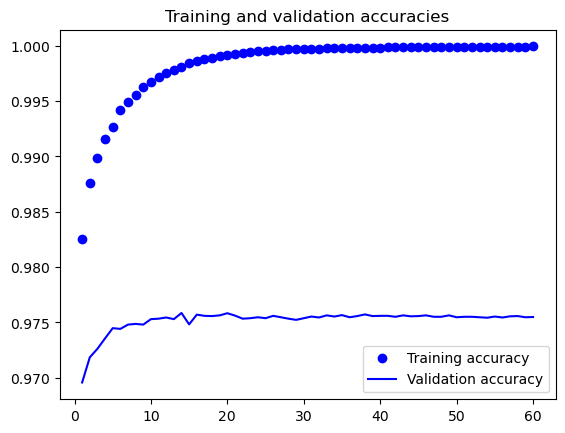

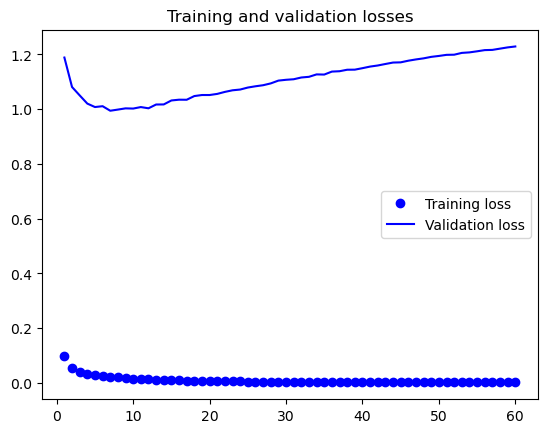

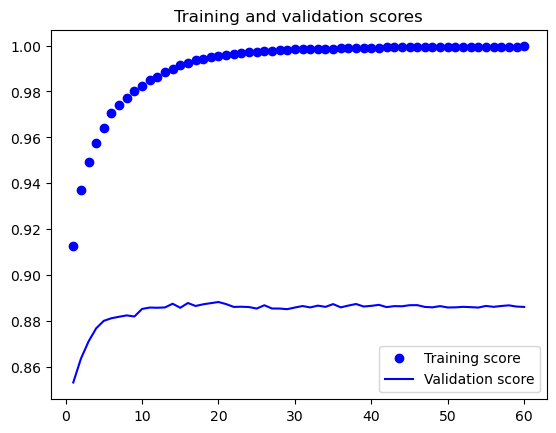

In [111]:
acc = history['accuracy']
loss = history['loss']
conll_score = history['conll_score']

val_acc = history['val_accuracy']
val_loss = history['val_loss']
val_conll_score = history['val_conll_score']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

if CORPUS in ['CONLL2000', 'CONLL2003']:
    plt.figure()
    plt.plot(epochs, conll_score, 'bo', label='Training score')
    plt.plot(epochs, val_conll_score, 'b', label='Validation score')
    plt.title('Training and validation scores')
    plt.legend()

plt.show()

### Predicting a Value

In [112]:
model = torch.load(MODEL_FILE, weights_only=False)
model.eval()

Model(
  (word_embs): Embedding(136492, 50)
  (cap_embs): Embedding(6, 5)
  (flatten): Flatten(start_dim=2, end_dim=-1)
  (fc1): Linear(in_features=275, out_features=300, bias=True)
  (hardth): Hardtanh(min_val=-1.0, max_val=1.0)
  (relu): ReLU()
  (fc2): Linear(in_features=300, out_features=18, bias=True)
  (crf): CRF()
)

We set the tagger model to the best model

In [113]:
tagger.model = model

In [114]:
Y_test_pred = model(X_test[1].unsqueeze(dim=0))
Y_test_pred

[[13, 13, 14, 13, 13, 13, 13, 14, 13, 13, 13, 13]]

In [115]:
list(map(lambda x: idx2pos.get(x, 'UNK'), Y_test_pred[0]))

['O', 'O', 'S-LOC', 'O', 'O', 'O', 'O', 'S-LOC', 'O', 'O', 'O', 'O']

### Testing the Model

In [116]:
loss_test = evaluate(model, test_dataloader)
loss_test

1.0517445309825817

In [117]:
target_names = sorted(pos2idx.keys(), key=lambda x: pos2idx[x])

In [118]:
target_names

['PAD',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'E-LOC',
 'E-MISC',
 'E-ORG',
 'E-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O',
 'S-LOC',
 'S-MISC',
 'S-ORG',
 'S-PER']

## Sentences

In [119]:
sentences = ["That round table might collapse .",
             "The man can learn well .",
             "The man can swim .",
             "The man can simwo .",
             'The Soviet Union might collapse .']

In [120]:
sd = [tagger.sent2dict(sent) for sent in sentences]
sd

[[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'learn', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': 'well', 'CAPS': 'NO_CAPS'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'swim', 'CAPS': 'NO_CAPS'},
  {'ID': 5, 'FORM': '.', 'CAPS': 'NO_CAPS'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS'},
  {'ID': 4, 'FORM': 'simwo', 'CAPS': 'NO_CA

In [121]:
tagger.predict_sentences(sd)

[[{'ID': 1, 'FORM': 'That', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'round', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'table', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'might', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': 'collapse', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'O'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'learn', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': 'well', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 6, 'FORM': '.', 'CAPS': 'NO_CAPS', 'PTAG': 'O'}],
 [{'ID': 1, 'FORM': 'The', 'CAPS': 'INIT_CAP', 'PTAG': 'O'},
  {'ID': 2, 'FORM': 'man', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 3, 'FORM': 'can', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 4, 'FORM': 'swim', 'CAPS': 'NO_CAPS', 'PTAG': 'O'},
  {'ID': 5, 'FORM': '.'

## Final Score
The final score is the CoNLL validation score for CoNLL 2000 and 2003 and the accuracy score on the test set for EWT.

In [122]:
pred_test_sents = tagger.predict_sentences(test_dict)

In [123]:
pred_test_sents[:2]

[[{'FORM': '-DOCSTART-',
   'PPOS': '-X-',
   'PCHUNK': '-X-',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'}],
 [{'FORM': 'SOCCER',
   'PPOS': 'NN',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': '-',
   'PPOS': ':',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'O'},
  {'FORM': 'JAPAN',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-LOC',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'S-LOC'},
  {'FORM': 'GET',
   'PPOS': 'VB',
   'PCHUNK': 'B-VP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': 'LUCKY',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': 'WIN',
   'PPOS': 'NNP',
   'PCHUNK': 'I-NP',
   'NER': 'O',
   'CAPS': 'ALL_CAPS',
   'PTAG': 'O'},
  {'FORM': ',',
   'PPOS': ',',
   'PCHUNK': 'O',
   'NER': 'O',
   'CAPS': 'NO_CAPS',
   'PTAG': 'O'},
  {'FORM': 'CHINA',
   'PPOS': 'NNP',
   'PCHUNK': 'B-NP',
   'NER': 'S-PER',
   'CAPS': 'ALL_CAPS',

In [124]:
if CORPUS in ['CONLL2000', 'CONLL2003']:
    chunker_score = scorer.conll_score(pred_test_sents)
    print(f'CoNLL score on the validation set: {chunker_score:.4f}')
elif CORPUS == 'EWT':
    accuracy = scorer.accuracy(pred_test_sents)
    print(f'Accuracy on the test set: {accuracy:.4f}')

CoNLL score on the validation set: 0.8883
